# UniVI 10x Multiome data integration demonstration/tutorial

Andrew Ashford, Pathways + Omics Group, Oregon Health & Science University - 11/18/2025

This Jupyter Notebook will be used to outline the training steps for a UniVI model using human PBMC 10x Genomics data.


#### Import modules

In [1]:
import os, sys, json
import numpy as np
import scanpy as sc
import torch
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import anndata as ad


In [2]:
# -------------------------
# 0. Wire up package import
# -------------------------
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from univi import (
    UniVIMultiModalVAE,
    ModalityConfig,
    UniVIConfig,
    TrainingConfig,
    matching,
)
from univi.data import MultiModalDataset
from univi.trainer import UniVITrainer


#### Read in and preprocess data as needed

In [3]:
# -------------------------
# 2. Load AnnData objects
# -------------------------
# Load RNA AnnData object
rna_adata = sc.read_h5ad("../data/PBMC_10x_Multiome_data/10x_Genomics_Multiome_data/10x-Multiome-Pbmc10k-RNA.h5ad")


In [4]:
# Sanity check
print(rna_adata)
print(rna_adata.X)
print(rna_adata.X.min())
print(rna_adata.X.max())


AnnData object with n_obs × n_vars = 9631 × 29095
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
  (0, 19)	1.0
  (0, 22)	1.0
  (0, 70)	1.0
  (0, 85)	1.0
  (0, 93)	1.0
  (0, 124)	3.0
  (0, 126)	5.0
  (0, 167)	1.0
  (0, 180)	2.0
  (0, 192)	2.0
  (0, 213)	1.0
  (0, 238)	1.0
  (0, 248)	1.0
  (0, 275)	1.0
  (0, 290)	1.0
  (0, 299)	2.0
  (0, 324)	1.0
  (0, 330)	1.0
  (0, 331)	2.0
  (0, 349)	1.0
  (0, 354)	1.0
  (0, 357)	1.0
  (0, 360)	1.0

In [5]:
# Load ADT AnnData object
atac_adata = sc.read_h5ad("../data/PBMC_10x_Multiome_data/10x_Genomics_Multiome_data/10x-Multiome-Pbmc10k-ATAC.h5ad")


In [6]:
# Sanity check
print(atac_adata)
print(atac_adata.X)
print(atac_adata.X.min())
print(atac_adata.X.max())


AnnData object with n_obs × n_vars = 9631 × 107194
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts'
  (0, 3)	2.0
  (0, 4)	2.0
  (0, 17)	2.0
  (0, 28)	1.0
  (0, 30)	4.0
  (0, 33)	2.0
  (0, 42)	2.0
  (0, 43)	2.0
  (0, 45)	2.0
  (0, 56)	6.0
  (0, 61)	4.0
  (0, 66)	4.0
  (0, 75)	6.0
  (0, 88)	4.0
  (0, 95)	2.0
  (0, 97)	2.0
  (0, 120)	8.0
  (0, 122)	2.0
  (0, 127)	1.0
  (0, 138)	2.0
  (0, 172)	4.0
  (0, 194)	3.0
  (0, 207)	2.0
  (0, 212)	6.0
  (0, 213)	2.0
  :	:
  (9630, 106911)	2.0
  (9630, 106916)	4.0
  (9630, 106953)	2.0
  (9630, 106967)	2.0
  (9630, 106990)	2.0
  (9630, 106993)	2.0
  (9630, 107022)	2.0
  (9630, 107032)	2.0
  (9630, 107034)	8.0
  (9630, 107042)	2.0
  (9630, 107047)	6.0
  (9630, 107069)	2.0

#### Initialize model and data via dataloaders

In [7]:
# =========================================
# UniVI on 10x Multiome PBMC (RNA + ATAC)
# =========================================
import numpy as np
import scanpy as sc
from scipy import sparse as sp
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

import torch
from torch.utils.data import DataLoader, Subset

from univi.config import UniVIConfig, ModalityConfig, TrainingConfig
from univi.data import MultiModalDataset
from univi.models.univi import UniVIMultiModalVAE
from univi.trainer import UniVITrainer

import matplotlib.pyplot as plt

# make plots a bit larger & high-res by default
plt.rcParams.update(
    {
        "figure.figsize": (18, 16),
        "figure.dpi": 200,
        "savefig.dpi": 300,
        "font.size": 10,
    }
)


In [8]:
# ------------------------------------------------------
# 0. Align cells between modalities (intersection + same order)
# ------------------------------------------------------
print("Original RNA:", rna_adata.shape)
print("Original ATAC:", atac_adata.shape)

shared_cells = rna_adata.obs_names.intersection(atac_adata.obs_names)
shared_cells = shared_cells.sort_values()  # deterministic order

rna_adata = rna_adata[shared_cells].copy()
atac_adata = atac_adata[shared_cells].copy()

rna_adata.var_names_make_unique()
atac_adata.var_names_make_unique()

print("After alignment:")
print("  RNA :", rna_adata.shape)
print("  ATAC:", atac_adata.shape)


Original RNA: (9631, 29095)
Original ATAC: (9631, 107194)
After alignment:
  RNA : (9631, 29095)
  ATAC: (9631, 107194)


In [9]:
# ------------------------------------------------------
# 1. RNA preprocessing: counts -> log1p - or just counts, use HVGs
# ------------------------------------------------------
'''
rna = rna_adata.copy()

# keep raw counts
if "counts" not in rna.layers:
    rna.layers["counts"] = rna.X.copy()

# if HVGs already defined, use them. Otherwise recompute.
if "highly_variable" in rna.var.columns and rna.var["highly_variable"].sum() > 0:
    hvg_mask = rna.var["highly_variable"].values
else:
    sc.pp.normalize_total(rna, target_sum=1e4)
    sc.pp.log1p(rna)
    sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
    hvg_mask = rna.var["highly_variable"].values

# redo normalization on HVGs cleanly
rna = rna[:, hvg_mask].copy()
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

rna.layers['log1p'] = rna.X
rna.X = rna.layers['counts']

print("RNA HVGs:", rna.n_vars)
'''

'\nrna = rna_adata.copy()\n\n# keep raw counts\nif "counts" not in rna.layers:\n    rna.layers["counts"] = rna.X.copy()\n\n# if HVGs already defined, use them. Otherwise recompute.\nif "highly_variable" in rna.var.columns and rna.var["highly_variable"].sum() > 0:\n    hvg_mask = rna.var["highly_variable"].values\nelse:\n    sc.pp.normalize_total(rna, target_sum=1e4)\n    sc.pp.log1p(rna)\n    sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")\n    hvg_mask = rna.var["highly_variable"].values\n\n# redo normalization on HVGs cleanly\nrna = rna[:, hvg_mask].copy()\nsc.pp.normalize_total(rna, target_sum=1e4)\nsc.pp.log1p(rna)\n\nrna.layers[\'log1p\'] = rna.X\nrna.X = rna.layers[\'counts\']\n\nprint("RNA HVGs:", rna.n_vars)\n'

In [10]:
# ===============================================
# OPTION C: RNA counts + ATAC peaks (counts/binary)
# ===============================================

# -----------------------------
# 1. RNA: HVGs, counts in .X
# -----------------------------
rna = rna_adata.copy()

# Ensure counts
if "counts" not in rna.layers:
    rna.layers["counts"] = rna.X.copy()

# HVG selection using log1p-normalized RNA
tmp = rna.copy()
sc.pp.normalize_total(tmp, target_sum=1e4)
sc.pp.log1p(tmp)

if "highly_variable" in tmp.var.columns and tmp.var["highly_variable"].sum() > 0:
    hvg_mask = tmp.var["highly_variable"].values
else:
    sc.pp.highly_variable_genes(
        tmp,
        n_top_genes=2000,
        flavor="seurat_v3"
    )
    hvg_mask = tmp.var["highly_variable"].values

# Subset to HVGs in counts space
rna = rna[:, hvg_mask].copy()
rna.layers["counts"] = rna.X.copy()

# Also keep log1p layer for diagnostics
tmp = tmp[:, hvg_mask].copy()
rna.layers["log1p"] = tmp.X.copy()

# Main matrix: counts
rna.X = rna.layers["counts"]

print("OPTION C – RNA HVGs (counts):", rna.shape)

# UniVI config:
#   input_dim (rna) = rna.n_vars
#   likelihood (rna) = "nb" or "zinb"


OPTION C – RNA HVGs (counts): (9631, 2000)


In [11]:
# ------------------------------------------------------
# 2. ATAC preprocessing: raw peaks -> TF-IDF -> LSI -> use LSI as features
# ------------------------------------------------------
'''
atac = atac_adata.copy()

if "counts" not in atac.layers:
    atac.layers["counts"] = atac.X.copy()

X_atac = atac.layers["counts"]
if not sp.isspmatrix_csr(X_atac):
    X_atac = sp.csr_matrix(X_atac)
'''

'\natac = atac_adata.copy()\n\nif "counts" not in atac.layers:\n    atac.layers["counts"] = atac.X.copy()\n\nX_atac = atac.layers["counts"]\nif not sp.isspmatrix_csr(X_atac):\n    X_atac = sp.csr_matrix(X_atac)\n'

In [12]:
'''
# TF-IDF
print("Computing TF-IDF for ATAC...")

# term frequency (rows normalized)
tf = normalize(X_atac, norm="l1", axis=1)

# inverse document frequency
peak_counts = np.asarray((X_atac > 0).sum(axis=0)).ravel()
idf = np.log1p(X_atac.shape[0] / (1 + peak_counts))
X_tfidf = tf.multiply(idf)
'''

'\n# TF-IDF\nprint("Computing TF-IDF for ATAC...")\n\n# term frequency (rows normalized)\ntf = normalize(X_atac, norm="l1", axis=1)\n\n# inverse document frequency\npeak_counts = np.asarray((X_atac > 0).sum(axis=0)).ravel()\nidf = np.log1p(X_atac.shape[0] / (1 + peak_counts))\nX_tfidf = tf.multiply(idf)\n'

In [13]:
'''
# LSI via truncated SVD
n_lsi = 200  # reasonable dimensionality for multiome

print(f"Computing LSI with {n_lsi} components...")

svd = TruncatedSVD(n_components=n_lsi, random_state=42)
X_lsi = svd.fit_transform(X_tfidf)
'''

'\n# LSI via truncated SVD\nn_lsi = 200  # reasonable dimensionality for multiome\n\nprint(f"Computing LSI with {n_lsi} components...")\n\nsvd = TruncatedSVD(n_components=n_lsi, random_state=42)\nX_lsi = svd.fit_transform(X_tfidf)\n'

In [14]:
'''
# center LSI dimensions
X_lsi = X_lsi - X_lsi.mean(axis=0, keepdims=True)
'''

'\n# center LSI dimensions\nX_lsi = X_lsi - X_lsi.mean(axis=0, keepdims=True)\n'

In [15]:
'''
import anndata as ad
import pandas as pd

# X_lsi: (cells, n_lsi)
n_lsi = X_lsi.shape[1]

atac_lsi = ad.AnnData(
    X=X_lsi.copy(),
    obs=atac.obs.copy(),
    var=pd.DataFrame(index=[f"LSI_{i+1}" for i in range(n_lsi)])
)

atac_lsi.obsm["X_lsi"] = X_lsi  # optional, but harmless
print(atac_lsi.shape)  # (9631, 200)
'''

'\nimport anndata as ad\nimport pandas as pd\n\n# X_lsi: (cells, n_lsi)\nn_lsi = X_lsi.shape[1]\n\natac_lsi = ad.AnnData(\n    X=X_lsi.copy(),\n    obs=atac.obs.copy(),\n    var=pd.DataFrame(index=[f"LSI_{i+1}" for i in range(n_lsi)])\n)\n\natac_lsi.obsm["X_lsi"] = X_lsi  # optional, but harmless\nprint(atac_lsi.shape)  # (9631, 200)\n'

In [16]:
'''
# Sanity check of the correct ATAC AnnData object to use
print(atac_lsi)
'''

'\n# Sanity check of the correct ATAC AnnData object to use\nprint(atac_lsi)\n'

In [17]:
'''
# ==============================================
# OPTION A: RNA log1p + ATAC LSI (both Gaussian)
# ==============================================

# -----------------------------
# 1. RNA: log1p-normalized HVGs
# -----------------------------
rna = rna_adata.copy()

# Keep raw counts in a layer
if "counts" not in rna.layers:
    rna.layers["counts"] = rna.X.copy()

# If HVGs exist, use them; otherwise compute
if "highly_variable" in rna.var.columns and rna.var["highly_variable"].sum() > 0:
    hvg_mask = rna.var["highly_variable"].values
else:
    sc.pp.normalize_total(rna, target_sum=1e4)
    sc.pp.log1p(rna)
    sc.pp.highly_variable_genes(
        rna,
        n_top_genes=2000,
        flavor="seurat_v3"
    )
    hvg_mask = rna.var["highly_variable"].values

# Subset to HVGs and redo clean normalization
rna = rna[:, hvg_mask].copy()
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

# Store log1p as main matrix (for Gaussian)
rna.layers["log1p"] = rna.X.copy()
# Keep counts for reference
rna.layers["counts"] = rna_adata[:, hvg_mask].X.copy()

print("OPTION A – RNA shape (HVGs, log1p in .X):", rna.shape)

# UniVI config:
#   input_dim (rna) = rna.n_vars
#   likelihood (rna) = "gaussian" or "mse"


# -------------------------------------------
# 2. ATAC: TF-IDF + LSI (reduced & z-scored)
# -------------------------------------------
atac = atac_adata.copy()

if "counts" not in atac.layers:
    atac.layers["counts"] = atac.X.copy()

X_atac = atac.layers["counts"]
if not sp.isspmatrix_csr(X_atac):
    X_atac = sp.csr_matrix(X_atac)

print("Computing TF-IDF for ATAC...")

# term frequency (row-normalized)
tf = normalize(X_atac, norm="l1", axis=1)

# inverse document frequency
peak_counts = np.asarray((X_atac > 0).sum(axis=0)).ravel()
idf = np.log1p(X_atac.shape[0] / (1 + peak_counts))

X_tfidf = tf.multiply(idf)

# LSI via truncated SVD
n_lsi = 50  # more conservative; tune 50–100
print(f"Computing LSI with {n_lsi} components...")

svd = TruncatedSVD(n_components=n_lsi, random_state=42)
X_lsi = svd.fit_transform(X_tfidf)  # (cells x n_lsi)

# Center and z-score each LSI dimension
X_lsi = X_lsi - X_lsi.mean(axis=0, keepdims=True)
X_lsi = X_lsi / (X_lsi.std(axis=0, keepdims=True) + 1e-8)

atac_proc = ad.AnnData(
    X=X_lsi.copy(),
    obs=atac.obs.copy(),
    var=pd.DataFrame(index=[f"LSI_{i+1}" for i in range(n_lsi)]),
)
atac_proc.layers["counts"] = X_atac  # keep raw peaks for later if needed
atac_proc.obsm["X_lsi"] = X_lsi

print("OPTION A – ATAC LSI shape:", atac_proc.shape)

# UniVI config:
#   input_dim (atac) = atac_proc.n_vars (= n_lsi)
#   likelihood (atac) = "gaussian" or "mse"
'''

'\n# ==============================================\n# OPTION A: RNA log1p + ATAC LSI (both Gaussian)\n# ==============================================\n\n# -----------------------------\n# 1. RNA: log1p-normalized HVGs\n# -----------------------------\nrna = rna_adata.copy()\n\n# Keep raw counts in a layer\nif "counts" not in rna.layers:\n    rna.layers["counts"] = rna.X.copy()\n\n# If HVGs exist, use them; otherwise compute\nif "highly_variable" in rna.var.columns and rna.var["highly_variable"].sum() > 0:\n    hvg_mask = rna.var["highly_variable"].values\nelse:\n    sc.pp.normalize_total(rna, target_sum=1e4)\n    sc.pp.log1p(rna)\n    sc.pp.highly_variable_genes(\n        rna,\n        n_top_genes=2000,\n        flavor="seurat_v3"\n    )\n    hvg_mask = rna.var["highly_variable"].values\n\n# Subset to HVGs and redo clean normalization\nrna = rna[:, hvg_mask].copy()\nsc.pp.normalize_total(rna, target_sum=1e4)\nsc.pp.log1p(rna)\n\n# Store log1p as main matrix (for Gaussian)\nrna.layers

In [18]:
'''
# ===========================================================
# OPTION B: RNA counts (NB) + ATAC LSI Gaussian (MSE decoder)
# ===========================================================

# -----------------------------
# 1. RNA: HVG selection + counts
# -----------------------------
rna = rna_adata.copy()

# Ensure counts layer
if "counts" not in rna.layers:
    rna.layers["counts"] = rna.X.copy()

# HVG selection done on log1p-normalized data
tmp = rna.copy()
sc.pp.normalize_total(tmp, target_sum=1e4)
sc.pp.log1p(tmp)

if "highly_variable" in tmp.var.columns and tmp.var["highly_variable"].sum() > 0:
    hvg_mask = tmp.var["highly_variable"].values
else:
    sc.pp.highly_variable_genes(
        tmp,
        n_top_genes=2000,
        flavor="seurat_v3"
    )
    hvg_mask = tmp.var["highly_variable"].values

# Subset RNA to HVGs *in counts space*
rna = rna[:, hvg_mask].copy()

# Also store log1p-normalized HVGs for plotting / sanity checks
tmp = tmp[:, hvg_mask].copy()
rna.layers["log1p"] = tmp.X.copy()

# Main matrix is counts for NB decoder
rna.X = rna.layers["counts"] = rna.X.copy()

print("OPTION B – RNA HVGs (counts in .X):", rna.shape)

# UniVI config:
#   input_dim (rna) = rna.n_vars
#   likelihood (rna) = "nb" or "zinb"


# ----------------------------------------
# 2. ATAC: TF-IDF + reduced, z-scored LSI
# ----------------------------------------
atac = atac_adata.copy()

if "counts" not in atac.layers:
    atac.layers["counts"] = atac.X.copy()

X_atac = atac.layers["counts"]
if not sp.isspmatrix_csr(X_atac):
    X_atac = sp.csr_matrix(X_atac)

print("Computing TF-IDF for ATAC (OPTION B)...")

tf = normalize(X_atac, norm="l1", axis=1)

peak_counts = np.asarray((X_atac > 0).sum(axis=0)).ravel()
idf = np.log1p(X_atac.shape[0] / (1 + peak_counts))

X_tfidf = tf.multiply(idf)

n_lsi = 50  # 50–100 is usually plenty
print(f"Computing LSI with {n_lsi} components...")

svd = TruncatedSVD(n_components=n_lsi, random_state=42)
X_lsi = svd.fit_transform(X_tfidf)

# Center + z-score
X_lsi = X_lsi - X_lsi.mean(axis=0, keepdims=True)
X_lsi = X_lsi / (X_lsi.std(axis=0, keepdims=True) + 1e-8)

atac_proc = ad.AnnData(
    X=X_lsi.copy(),
    obs=atac.obs.copy(),
    var=pd.DataFrame(index=[f"LSI_{i+1}" for i in range(n_lsi)]),
)
atac_proc.layers["counts"] = X_atac
atac_proc.obsm["X_lsi"] = X_lsi

print("OPTION B – ATAC LSI shape:", atac_proc.shape)

# UniVI config:
#   input_dim (atac) = atac_proc.n_vars (= n_lsi)
#   likelihood (atac) = "gaussian" or "mse"
'''

'\n# ===========================================================\n# OPTION B: RNA counts (NB) + ATAC LSI Gaussian (MSE decoder)\n# ===========================================================\n\n# -----------------------------\n# 1. RNA: HVG selection + counts\n# -----------------------------\nrna = rna_adata.copy()\n\n# Ensure counts layer\nif "counts" not in rna.layers:\n    rna.layers["counts"] = rna.X.copy()\n\n# HVG selection done on log1p-normalized data\ntmp = rna.copy()\nsc.pp.normalize_total(tmp, target_sum=1e4)\nsc.pp.log1p(tmp)\n\nif "highly_variable" in tmp.var.columns and tmp.var["highly_variable"].sum() > 0:\n    hvg_mask = tmp.var["highly_variable"].values\nelse:\n    sc.pp.highly_variable_genes(\n        tmp,\n        n_top_genes=2000,\n        flavor="seurat_v3"\n    )\n    hvg_mask = tmp.var["highly_variable"].values\n\n# Subset RNA to HVGs *in counts space*\nrna = rna[:, hvg_mask].copy()\n\n# Also store log1p-normalized HVGs for plotting / sanity checks\ntmp = tmp[:, 

In [19]:
'''
# ===============================================
# OPTION C: RNA counts + ATAC peaks (counts/binary)
# ===============================================

# -----------------------------
# 1. RNA: HVGs, counts in .X
# -----------------------------
rna = rna_adata.copy()

# Ensure counts
if "counts" not in rna.layers:
    rna.layers["counts"] = rna.X.copy()

# HVG selection using log1p-normalized RNA
tmp = rna.copy()
sc.pp.normalize_total(tmp, target_sum=1e4)
sc.pp.log1p(tmp)

if "highly_variable" in tmp.var.columns and tmp.var["highly_variable"].sum() > 0:
    hvg_mask = tmp.var["highly_variable"].values
else:
    sc.pp.highly_variable_genes(
        tmp,
        n_top_genes=2000,
        flavor="seurat_v3"
    )
    hvg_mask = tmp.var["highly_variable"].values

# Subset to HVGs in counts space
rna = rna[:, hvg_mask].copy()
rna.layers["counts"] = rna.X.copy()

# Also keep log1p layer for diagnostics
tmp = tmp[:, hvg_mask].copy()
rna.layers["log1p"] = tmp.X.copy()

# Main matrix: counts
rna.X = rna.layers["counts"]

print("OPTION C – RNA HVGs (counts):", rna.shape)

# UniVI config:
#   input_dim (rna) = rna.n_vars
#   likelihood (rna) = "nb" or "zinb"
'''

'\n# ===============================================\n# OPTION C: RNA counts + ATAC peaks (counts/binary)\n# ===============================================\n\n# -----------------------------\n# 1. RNA: HVGs, counts in .X\n# -----------------------------\nrna = rna_adata.copy()\n\n# Ensure counts\nif "counts" not in rna.layers:\n    rna.layers["counts"] = rna.X.copy()\n\n# HVG selection using log1p-normalized RNA\ntmp = rna.copy()\nsc.pp.normalize_total(tmp, target_sum=1e4)\nsc.pp.log1p(tmp)\n\nif "highly_variable" in tmp.var.columns and tmp.var["highly_variable"].sum() > 0:\n    hvg_mask = tmp.var["highly_variable"].values\nelse:\n    sc.pp.highly_variable_genes(\n        tmp,\n        n_top_genes=2000,\n        flavor="seurat_v3"\n    )\n    hvg_mask = tmp.var["highly_variable"].values\n\n# Subset to HVGs in counts space\nrna = rna[:, hvg_mask].copy()\nrna.layers["counts"] = rna.X.copy()\n\n# Also keep log1p layer for diagnostics\ntmp = tmp[:, hvg_mask].copy()\nrna.layers["log1p"] = 

In [20]:
# ---------------------------------------------
# 2C1. ATAC: peak counts (for NB / Poisson)
# ---------------------------------------------
atac = atac_adata.copy()

# Ensure counts
if "counts" not in atac.layers:
    atac.layers["counts"] = atac.X.copy()

X_atac = atac.layers["counts"]
if not sp.isspmatrix_csr(X_atac):
    X_atac = sp.csr_matrix(X_atac)

# Simple peak filtering: keep peaks present in >= min_cells
min_cells_per_peak = 25  # tune this
peak_counts = np.asarray((X_atac > 0).sum(axis=0)).ravel()
keep_peaks = peak_counts >= min_cells_per_peak

print(f"Keeping {keep_peaks.sum()} / {len(keep_peaks)} peaks with ≥{min_cells_per_peak} cells")

atac = atac[:, keep_peaks].copy()
X_atac = atac.layers["counts"] = atac.X.copy()

# (optional) you could further take top N peaks by variance
peak_var = np.asarray(X_atac.power(2).mean(axis=0) - np.square(X_atac.mean(axis=0))).ravel()
top_n = 5000
top_idx = np.argsort(peak_var)[-top_n:]
atac = atac[:, top_idx].copy()
X_atac = atac.layers["counts"] = atac.X.copy()

# Main matrix: counts
atac.X = X_atac

print("OPTION C1 – ATAC peaks (counts) shape:", atac.shape)

# UniVI config:
#   input_dim (atac) = atac.n_vars  (number of peaks)
#   likelihood (atac) = "nb"  (or "poisson" if you want)


Keeping 102712 / 107194 peaks with ≥25 cells
OPTION C1 – ATAC peaks (counts) shape: (9631, 5000)


In [21]:
'''
# ---------------------------------------------
# 2C2. ATAC: binarized peak presence (Bernoulli)
# ---------------------------------------------
atac_bin = atac_adata.copy()

# Ensure counts
if "counts" not in atac_bin.layers:
    atac_bin.layers["counts"] = atac_bin.X.copy()

X_atac = atac_bin.layers["counts"]
if not sp.isspmatrix_csr(X_atac):
    X_atac = sp.csr_matrix(X_atac)

# Peak filter as before
min_cells_per_peak = 50
peak_counts = np.asarray((X_atac > 0).sum(axis=0)).ravel()
keep_peaks = peak_counts >= min_cells_per_peak

print(f"Keeping {keep_peaks.sum()} / {len(keep_peaks)} peaks with ≥{min_cells_per_peak} cells (binary)")

atac_bin = atac_bin[:, keep_peaks].copy()
X_atac = atac_bin.layers["counts"] = atac_bin.X.copy()

# Binarize presence/absence
X_bin = (X_atac > 0).astype(np.float32)
atac_bin.X = X_bin  # main matrix is 0/1

print("OPTION C2 – ATAC peaks (binary) shape:", atac_bin.shape)

# UniVI config:
#   input_dim (atac) = atac_bin.n_vars
#   likelihood (atac) = "bernoulli"
'''

'\n# ---------------------------------------------\n# 2C2. ATAC: binarized peak presence (Bernoulli)\n# ---------------------------------------------\natac_bin = atac_adata.copy()\n\n# Ensure counts\nif "counts" not in atac_bin.layers:\n    atac_bin.layers["counts"] = atac_bin.X.copy()\n\nX_atac = atac_bin.layers["counts"]\nif not sp.isspmatrix_csr(X_atac):\n    X_atac = sp.csr_matrix(X_atac)\n\n# Peak filter as before\nmin_cells_per_peak = 50\npeak_counts = np.asarray((X_atac > 0).sum(axis=0)).ravel()\nkeep_peaks = peak_counts >= min_cells_per_peak\n\nprint(f"Keeping {keep_peaks.sum()} / {len(keep_peaks)} peaks with ≥{min_cells_per_peak} cells (binary)")\n\natac_bin = atac_bin[:, keep_peaks].copy()\nX_atac = atac_bin.layers["counts"] = atac_bin.X.copy()\n\n# Binarize presence/absence\nX_bin = (X_atac > 0).astype(np.float32)\natac_bin.X = X_bin  # main matrix is 0/1\n\nprint("OPTION C2 – ATAC peaks (binary) shape:", atac_bin.shape)\n\n# UniVI config:\n#   input_dim (atac) = atac_bin.n_

In [23]:
# Make "atac_lsi" for the UMAPs..
atac_lsi = atac.copy()


In [24]:
# ------------------------------------------------------
# 3. Sanity: check cell_type labels
# ------------------------------------------------------
assert "cell_type" in rna.obs.columns, "rna.obs['cell_type'] is required."
assert np.all(rna.obs["cell_type"].values == atac_lsi.obs["cell_type"].values), \
    "cell_type must be aligned across RNA and ATAC."

print("Cell types:", sorted(list(rna.obs["cell_type"].cat.categories)))


Cell types: ['CD14 Mono', 'CD16 Mono', 'CD4 Naive', 'CD4 TCM', 'CD4 TEM', 'CD8 Naive', 'CD8 TEM_1', 'CD8 TEM_2', 'HSPC', 'Intermediate B', 'MAIT', 'Memory B', 'NK', 'Naive B', 'Plasma', 'Treg', 'cDC', 'gdT', 'pDC']


In [25]:
# Plot quick UMAPs to look at the RNA and the ATAC features colored by cell type
import scanpy as sc

# Make plots a bit bigger / nicer
sc.settings.set_figure_params(dpi=200, figsize=(18, 16))

# Change this to whatever your celltype column is
color_key = "cell_type"   # e.g. "celltype", "leiden", etc.


In [26]:
# =========================
# 1) RNA: UMAP from rna.X
# =========================
print("RNA shape:", rna.shape)

# Make a shallow copy for PCA so we don't touch the original rna.X
rna_pca = rna.copy()

# Use the log1p layer as X for PCA
rna_pca.X = rna.layers["log1p"].copy()

# Optional: scale before PCA (common for log1p data)
sc.pp.scale(rna_pca, max_value=10)

# Run PCA on the log1p data
sc.tl.pca(rna_pca, n_comps=50)

# Copy the PCA results back to the original object
rna.obsm["X_pca"] = rna_pca.obsm["X_pca"]
rna.varm["PCs"]   = rna_pca.varm["PCs"]

# Now compute neighbors / UMAP on rna using those PCs
sc.pp.neighbors(rna, use_rep="X_pca", n_pcs=30)
sc.tl.umap(rna)


RNA shape: (9631, 2000)


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


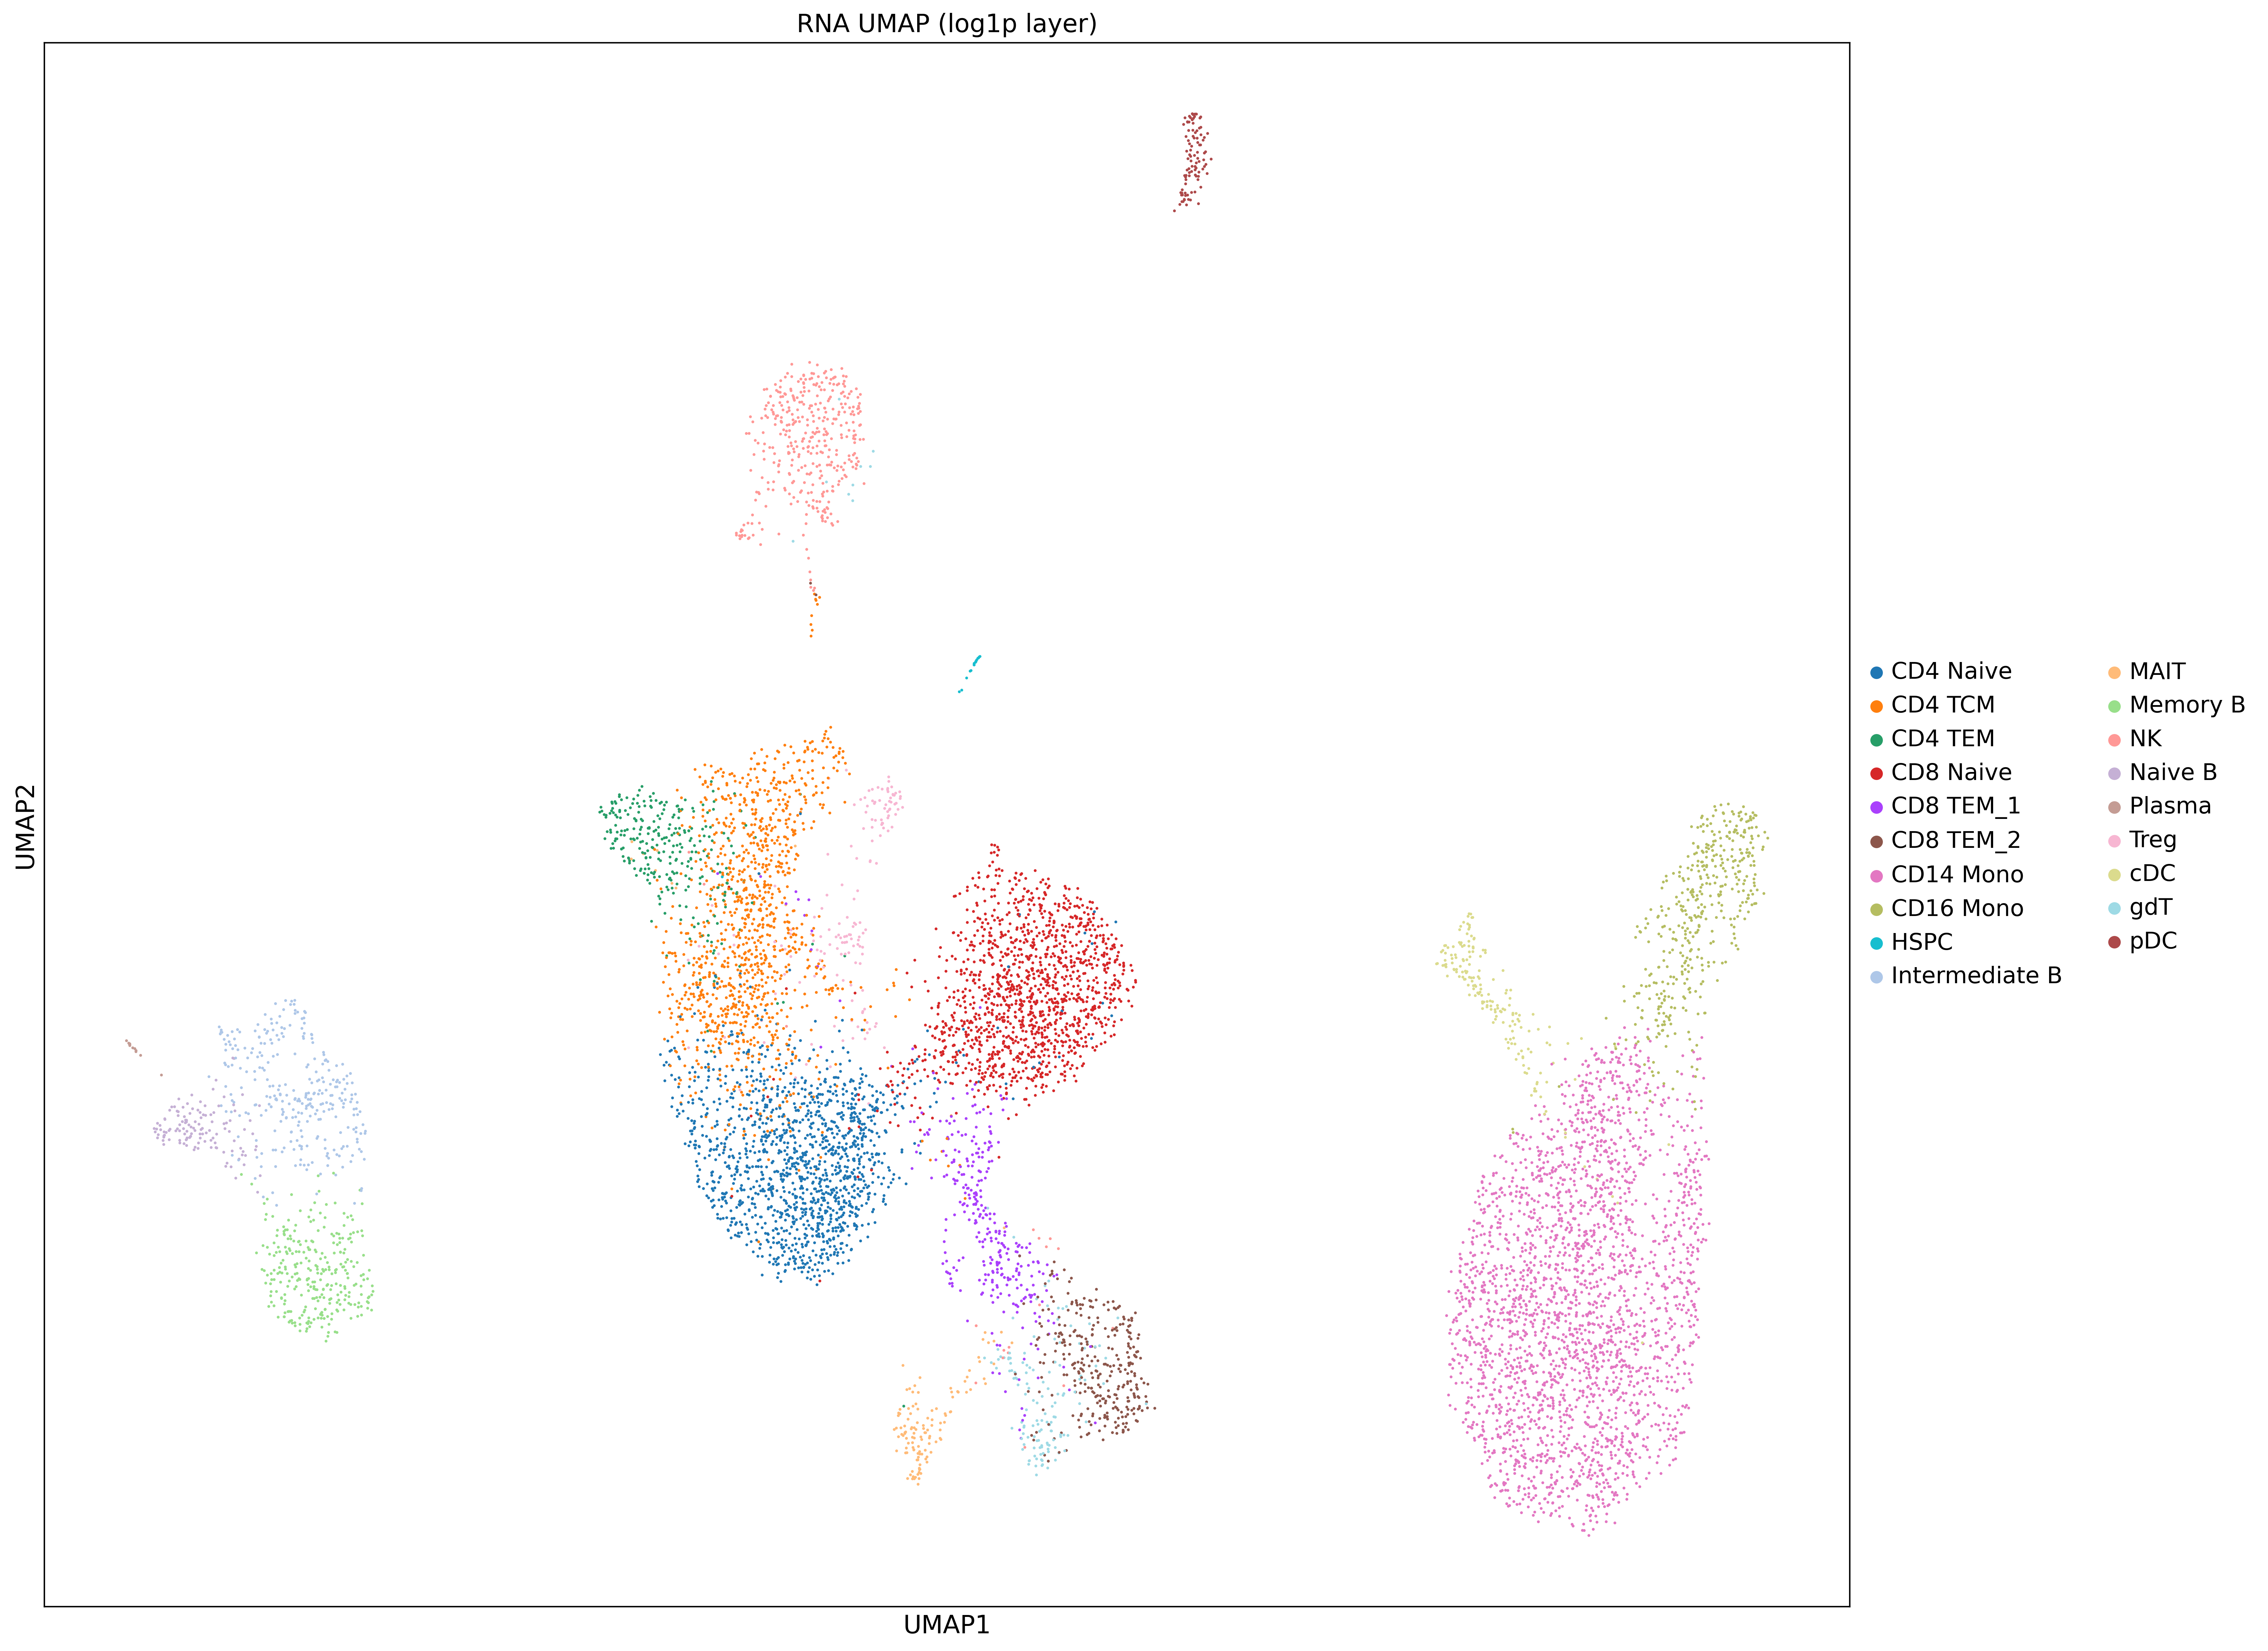

In [27]:
sc.pl.umap(
    rna,
    color="cell_type",  # or whatever key you want
    size=10,
    title="RNA UMAP (log1p layer)",
)


In [28]:
# =========================
# 2) ATAC: UMAP from atac_lsi.X
# =========================
print("ATAC shape:", atac_lsi.shape)

# If you already computed LSI and stored as obsm["X_lsi"],
# use that; otherwise fall back to PCA on X (quick & dirty).
if "X_lsi" in atac_lsi.obsm:
    sc.pp.neighbors(atac_lsi, use_rep="X_lsi", n_neighbors=15)
else:
    sc.pp.scale(atac_lsi, max_value=10)
    sc.tl.pca(atac_lsi, n_comps=50)
    sc.pp.neighbors(atac_lsi, n_pcs=30)

sc.tl.umap(atac_lsi)


ATAC shape: (9631, 5000)


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


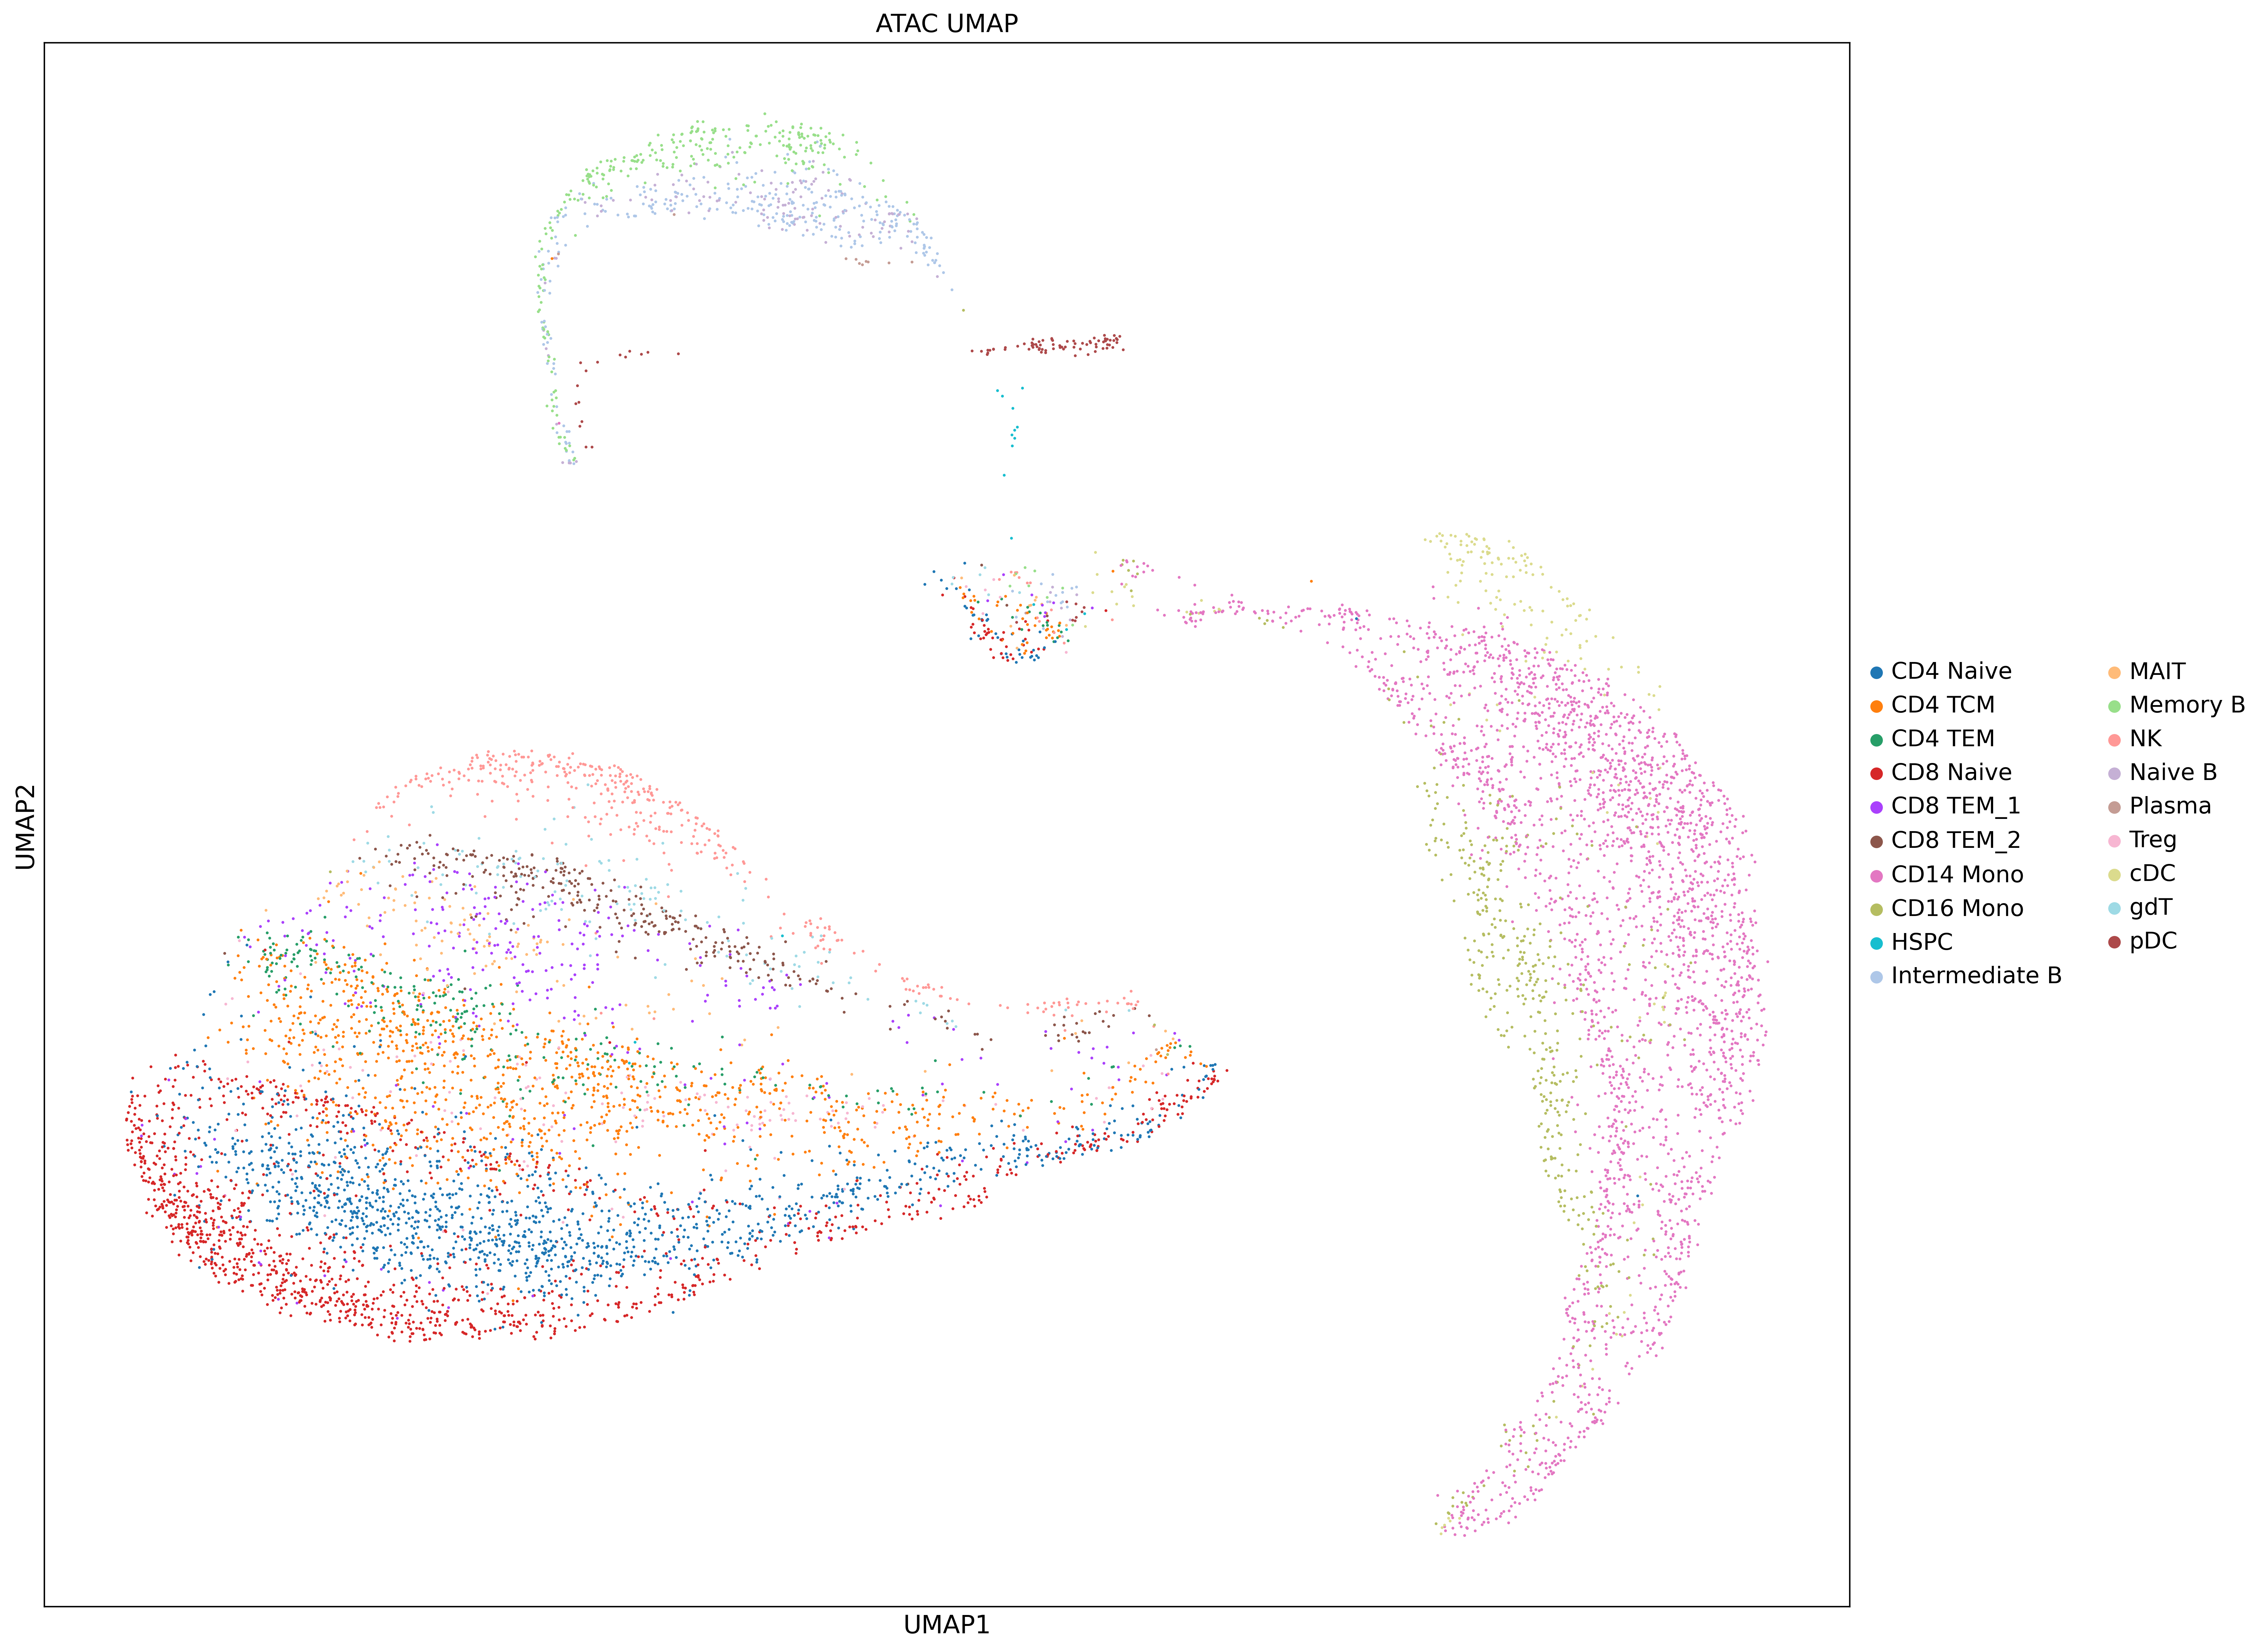

In [29]:
sc.pl.umap(
    atac_lsi,
    color=color_key,
    size=10,
    title="ATAC UMAP",
)


In [30]:
# ------------------------------------------------------
# 4. Balanced split by cell_type (max 1000 per type)
# ------------------------------------------------------
def make_stratified_indices_by_celltype(
    adata,
    label_key="cell_type",
    max_per_type=1000,
    frac_train=0.8,
    frac_val=0.1,
    seed=42,
):
    rng = np.random.default_rng(seed)
    labels = adata.obs[label_key].astype(str).values
    unique_ct = np.unique(labels)

    train_idx = []
    val_idx   = []
    test_idx  = []
    unused_idx = []

    per_ct_counts = {}

    for ct in unique_ct:
        idx_ct = np.where(labels == ct)[0]
        rng.shuffle(idx_ct)

        # cap per type
        if idx_ct.size > max_per_type:
            in_scope = idx_ct[:max_per_type]
            extra    = idx_ct[max_per_type:]
            unused_idx.append(extra)
        else:
            in_scope = idx_ct
            extra    = np.array([], dtype=int)

        n = in_scope.size
        if n == 0:
            continue

        # per-celltype splits
        n_train = int(frac_train * n)
        n_val   = int(frac_val   * n)
        # everything else is test
        n_test  = n - n_train - n_val
        if n_test < 0:
            n_test = 0

        ct_train = in_scope[:n_train]
        ct_val   = in_scope[n_train:n_train + n_val]
        ct_test  = in_scope[n_train + n_val:]

        train_idx.append(ct_train)
        val_idx.append(ct_val)
        test_idx.append(ct_test)

        per_ct_counts[ct] = {
            "total": idx_ct.size,
            "used": n,
            "train": ct_train.size,
            "val": ct_val.size,
            "test": ct_test.size,
            "unused_extra": extra.size,
        }

    train_idx = np.concatenate(train_idx) if train_idx else np.array([], dtype=int)
    val_idx   = np.concatenate(val_idx)   if val_idx   else np.array([], dtype=int)
    test_idx  = np.concatenate(test_idx)  if test_idx  else np.array([], dtype=int)
    unused_idx_extra = (
        np.concatenate(unused_idx) if unused_idx else np.array([], dtype=int)
    )

    # any cells not in train/val/test go to unused as well (paranoia)
    n_cells = adata.n_obs
    all_idx = np.arange(n_cells)
    used_idx = np.unique(np.concatenate([train_idx, val_idx, test_idx]))
    unused_rest = np.setdiff1d(all_idx, used_idx)

    unused_idx = np.unique(np.concatenate([unused_idx_extra, unused_rest]))

    print("Balanced split summary:")
    print(f"  Train: {train_idx.size}")
    print(f"  Val:   {val_idx.size}")
    print(f"  Test:  {test_idx.size}")
    print(f"  Unused: {unused_idx.size}")
    print("\nPer-celltype counts (total / used / train / val / test / unused_extra):")
    for ct, d in per_ct_counts.items():
        print(
            f"  {ct:15s} "
            f"{d['total']:5d} / {d['used']:5d} / "
            f"{d['train']:5d} / {d['val']:5d} / {d['test']:5d} / {d['unused_extra']:5d}"
        )

    return train_idx, val_idx, test_idx, unused_idx, per_ct_counts


train_idx, val_idx, test_idx, unused_idx, ct_stats = make_stratified_indices_by_celltype(
    rna,
    label_key="cell_type",
    max_per_type=1500,
    frac_train=0.8,
    frac_val=0.1,
    seed=42,
)

# Build aligned subsets for each modality
rna_train  = rna[train_idx].copy()
rna_val    = rna[val_idx].copy()
rna_test   = rna[test_idx].copy()
rna_unused = rna[unused_idx].copy()

atac_train  = atac_lsi[train_idx].copy()
atac_val    = atac_lsi[val_idx].copy()
atac_test   = atac_lsi[test_idx].copy()
atac_unused = atac_lsi[unused_idx].copy()

print("\nSubset shapes:")
print("  RNA train/val/test/unused:",
      rna_train.n_obs, rna_val.n_obs, rna_test.n_obs, rna_unused.n_obs)
print("  ATAC train/val/test/unused:",
      atac_train.n_obs, atac_val.n_obs, atac_test.n_obs, atac_unused.n_obs)


Balanced split summary:
  Train: 6855
  Val:   851
  Test:  871
  Unused: 1054

Per-celltype counts (total / used / train / val / test / unused_extra):
  CD14 Mono        2554 /  1500 /  1200 /   150 /   150 /  1054
  CD16 Mono         442 /   442 /   353 /    44 /    45 /     0
  CD4 Naive        1382 /  1382 /  1105 /   138 /   139 /     0
  CD4 TCM          1113 /  1113 /   890 /   111 /   112 /     0
  CD4 TEM           286 /   286 /   228 /    28 /    30 /     0
  CD8 Naive        1354 /  1354 /  1083 /   135 /   136 /     0
  CD8 TEM_1         322 /   322 /   257 /    32 /    33 /     0
  CD8 TEM_2         315 /   315 /   252 /    31 /    32 /     0
  HSPC               17 /    17 /    13 /     1 /     3 /     0
  Intermediate B    300 /   300 /   240 /    30 /    30 /     0
  MAIT              130 /   130 /   104 /    13 /    13 /     0
  Memory B          298 /   298 /   238 /    29 /    31 /     0
  NK                403 /   403 /   322 /    40 /    41 /     0
  Naive B       

In [31]:
# Sanity check the .X values to see what you'll be training on..
# For this run, want raw counts for RNA and LSI for ATAC data. The model will use an NB decoder for RNA and a 
# MSE for a continuous latent decoder.
print(rna.X)
print(rna.X.min())
print(rna.X.max())

print(atac_lsi.X)
print(atac_lsi.X.min())
print(atac_lsi.X.max())


  (0, 1)	1.0
  (0, 7)	1.0
  (0, 43)	6.0
  (0, 73)	1.0
  (0, 75)	3.0
  (0, 77)	3.0
  (0, 85)	1.0
  (0, 86)	2.0
  (0, 90)	1.0
  (0, 100)	4.0
  (0, 103)	6.0
  (0, 104)	3.0
  (0, 131)	5.0
  (0, 148)	1.0
  (0, 151)	1.0
  (0, 199)	1.0
  (0, 211)	2.0
  (0, 220)	1.0
  (0, 255)	1.0
  (0, 264)	1.0
  (0, 287)	2.0
  (0, 293)	2.0
  (0, 346)	1.0
  (0, 352)	1.0
  (0, 400)	2.0
  :	:
  (9630, 1568)	2.0
  (9630, 1576)	1.0
  (9630, 1598)	5.0
  (9630, 1599)	1.0
  (9630, 1657)	2.0
  (9630, 1672)	1.0
  (9630, 1675)	8.0
  (9630, 1710)	4.0
  (9630, 1752)	1.0
  (9630, 1753)	1.0
  (9630, 1754)	3.0
  (9630, 1769)	1.0
  (9630, 1780)	3.0
  (9630, 1782)	1.0
  (9630, 1801)	3.0
  (9630, 1805)	5.0
  (9630, 1824)	1.0
  (9630, 1837)	1.0
  (9630, 1862)	1.0
  (9630, 1870)	1.0
  (9630, 1880)	1.0
  (9630, 1938)	16.0
  (9630, 1945)	1.0
  (9630, 1991)	2.0
  (9630, 1999)	26.0
0.0
5585.0
[[-0.6425837   1.7672244  -0.63559663 ... -0.6232161  -0.84948677
   0.12106451]
 [-0.6425837  -0.6504089   0.5732168  ... -0.41113943 -0.0402

In [32]:
# ------------------------------------------------------
# 5. Build MultiModalDataset & DataLoaders
# ------------------------------------------------------
adata_dict_full = {
    "rna": rna,
    "atac": atac,
}

dataset = MultiModalDataset(
    adata_dict=adata_dict_full,
    X_key="X",
    device="cpu",  # will override with train_cfg.device if needed
)

# DataLoader expects indices into this `dataset`, so we reuse our arrays.
# These indices are consistent because we built them on `rna` which matches `dataset`.
train_ds = Subset(dataset, train_idx)
val_ds   = Subset(dataset, val_idx)

batch_size = 512

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)

# ------------------------------------------------------
# 6. UniVI configs
#   RNA: NB decoder (counts-like), ATAC: MSE on LSI (continuous, can be negative)
# ------------------------------------------------------
univi_cfg = UniVIConfig(
    latent_dim=60,
    beta=100.0,
    gamma=120.0,
    encoder_dropout=0.0,
    decoder_dropout=0.0,
    encoder_batchnorm=True,
    decoder_batchnorm=False,
    kl_anneal_start=5,
    kl_anneal_end=45,
    align_anneal_start=5,
    align_anneal_end=45,
    modalities=[
        ModalityConfig(
            name="rna",
            input_dim=rna.n_vars,
            encoder_hidden=[512, 256],
            decoder_hidden=[256, 512],
            likelihood="nb",
        ),
        ModalityConfig(
            name="atac",
            input_dim=atac.X.shape[1],
            encoder_hidden=[512, 256],
            decoder_hidden=[256, 512],
            #likelihood="mse",  # continuous latent (LSI)
            likelihood="nb",  # raw peaks, could also use Poisson distribution
        ),
    ],
)

train_cfg = TrainingConfig(
    n_epochs=250,
    batch_size=batch_size,
    lr=1e-3,
    weight_decay=1e-4,
    device="cpu",  # or "cuda"
    log_every=10,
    grad_clip=5.0,
    num_workers=0,
    seed=42,
    early_stopping=True,
    patience=20,
    min_delta=0.0,
)

device = train_cfg.device

model = UniVIMultiModalVAE(univi_cfg).to(device)
trainer = UniVITrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_cfg=train_cfg,
    device=device,
)

print(train_cfg)
print(univi_cfg)


[2025-11-19 12:25:59,784] [UniVITrainer] [INFO] TrainingConfig:
[2025-11-19 12:25:59,791] [UniVITrainer] [INFO]   n_epochs: 250
[2025-11-19 12:25:59,793] [UniVITrainer] [INFO]   batch_size: 512
[2025-11-19 12:25:59,794] [UniVITrainer] [INFO]   lr: 0.001
[2025-11-19 12:25:59,796] [UniVITrainer] [INFO]   weight_decay: 0.0001
[2025-11-19 12:25:59,797] [UniVITrainer] [INFO]   device: cpu
[2025-11-19 12:25:59,799] [UniVITrainer] [INFO]   log_every: 10
[2025-11-19 12:25:59,800] [UniVITrainer] [INFO]   grad_clip: 5.0
[2025-11-19 12:25:59,802] [UniVITrainer] [INFO]   num_workers: 0
[2025-11-19 12:25:59,803] [UniVITrainer] [INFO]   seed: 42
[2025-11-19 12:25:59,805] [UniVITrainer] [INFO]   early_stopping: True
[2025-11-19 12:25:59,806] [UniVITrainer] [INFO]   patience: 20
[2025-11-19 12:25:59,808] [UniVITrainer] [INFO]   min_delta: 0.0


TrainingConfig(n_epochs=250, batch_size=512, lr=0.001, weight_decay=0.0001, device='cpu', log_every=10, grad_clip=5.0, num_workers=0, seed=42, early_stopping=True, patience=20, min_delta=0.0)
UniVIConfig(latent_dim=60, modalities=[ModalityConfig(name='rna', input_dim=2000, encoder_hidden=[512, 256], decoder_hidden=[256, 512], likelihood='nb'), ModalityConfig(name='atac', input_dim=5000, encoder_hidden=[512, 256], decoder_hidden=[256, 512], likelihood='nb')], beta=100.0, gamma=120.0, encoder_dropout=0.0, decoder_dropout=0.0, encoder_batchnorm=True, decoder_batchnorm=False, kl_anneal_start=5, kl_anneal_end=45, align_anneal_start=5, align_anneal_end=45)


#### Train model

In [ ]:
# -------------------------
# 7. Train!
# -------------------------
history = trainer.fit()

# Quick training curves
fig, ax = plt.subplots()
ax.plot(history["train_loss"], label="train")
ax.plot(history["val_loss"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("UniVI Multiome training curves")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(history["beta"], label="beta")
ax.plot(history["gamma"], label="gamma")
ax.set_xlabel("Epoch")
ax.set_ylabel("Weight")
ax.set_title("KL / alignment annealing")
ax.legend()
plt.tight_layout()
plt.show()


Training UniVI:   0%|          | 0/250 [00:00<?, ?it/s]

[2025-11-19 12:35:03,763] [UniVITrainer] [INFO] [Epoch 001] Train loss: 10744.3275 (beta=0.000, gamma=0.000)
[2025-11-19 12:35:24,843] [UniVITrainer] [INFO] [Epoch 001] Val loss: 9933.8213 (beta=0.000, gamma=0.000)
[2025-11-19 12:35:25,146] [UniVITrainer] [INFO] [Epoch 001] New best val loss: 9933.8213
[2025-11-19 12:44:53,046] [UniVITrainer] [INFO] [Epoch 002] New best val loss: 9415.3574
[2025-11-19 12:53:57,399] [UniVITrainer] [INFO] [Epoch 003] New best val loss: 9328.9526
[2025-11-19 13:03:03,717] [UniVITrainer] [INFO] [Epoch 004] New best val loss: 9290.4229
[2025-11-19 13:12:05,105] [UniVITrainer] [INFO] [Epoch 005] New best val loss: 9252.0776
[2025-11-19 13:57:08,741] [UniVITrainer] [INFO] [Epoch 010] Train loss: 9305.5216 (beta=12.500, gamma=15.000)
[2025-11-19 13:57:28,407] [UniVITrainer] [INFO] [Epoch 010] Val loss: 9371.9072 (beta=12.500, gamma=15.000)


In [ ]:
print(history)


In [ ]:
from dataclasses import asdict

os.makedirs("../saved_models", exist_ok=True)

# after training
#history = trainer.fit()

# trainer.model already has the best weights (because we restored best_state_dict)
ckpt_path = "../saved_models/univi_10x_multiome_pbmc_celltype_1k_cap_beta_100_gamma_120_60_latent_dims.pt"
torch.save(
    {
        "state_dict": trainer.model.state_dict(),
        "univi_cfg": asdict(univi_cfg),
        "best_epoch": trainer.best_epoch,
        "best_val_loss": trainer.best_val_loss,
    },
    ckpt_path,
)
print("Saved best model to:", ckpt_path)


#### Evaluate model

In [ ]:
# Later to reload model
import torch
from univi.config import UniVIConfig, ModalityConfig
from univi.models.univi import UniVIMultiModalVAE

device = "cpu"  # or "cuda" if available

ckpt = torch.load(
    "../saved_models/univi_10x_multiome_pbmc_celltype_1k_cap_beta_100_gamma_120_60_latent_dims.pt",
    map_location=device,
)

# ---- Rebuild UniVIConfig, making sure modalities are ModalityConfig objects ----
cfg_dict = ckpt["univi_cfg"]

# If this is an OmegaConf object or similar, make sure it's a plain dict
try:
    from omegaconf import DictConfig, OmegaConf
    if isinstance(cfg_dict, DictConfig):
        cfg_dict = OmegaConf.to_container(cfg_dict, resolve=True)
except ImportError:
    pass

# Now rehydrate each modality
modalities = [ModalityConfig(**m) for m in cfg_dict["modalities"]]
cfg_dict = {**cfg_dict, "modalities": modalities}

univi_cfg_loaded = UniVIConfig(**cfg_dict)

# ---- Rebuild model + load weights ----
model_loaded = UniVIMultiModalVAE(univi_cfg_loaded).to(device)
model_loaded.load_state_dict(ckpt["state_dict"])

print("Best epoch was:", ckpt.get("best_epoch"), "val loss =", ckpt.get("best_val_loss"))


In [ ]:
# ============================
# UniVI Multiome evaluation (RNA + ATAC)
# ============================
import numpy as np
import torch
import scipy.sparse as sp
import matplotlib.pyplot as plt

from univi import evaluation as univi_eval
from univi import plotting as univi_plot

device = train_cfg.device

# -------------------------
# 1. Encode latent embeddings for TEST sets
# -------------------------
z_rna  = univi_eval.encode_adata(model, rna_test,  modality="rna",  device=device)
z_atac = univi_eval.encode_adata(model, atac_test, modality="atac", device=device)

rna_test.obsm["X_univi"]  = z_rna
atac_test.obsm["X_univi"] = z_atac

print("Latent shapes (test):")
print("  RNA :", z_rna.shape)
print("  ATAC:", z_atac.shape)


In [ ]:
# -------------------------
# 2. FOSCTTM (pairwise alignment quality)
# -------------------------
fos_rna_atac = univi_eval.compute_foscttm(z_rna, z_atac)
print(f"\nFOSCTTM RNA vs ATAC (lower = better): {fos_rna_atac:.4f}")

# maybe visualize FOSCTTM distribution if function returns per-cell; if not, skip


In [ ]:
# -------------------------
# 3. Modality mixing (RNA / ATAC)
# -------------------------
import numpy as np
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt

# Joint latent matrix for mixing metric
Z_joint = np.concatenate([z_rna, z_atac], axis=0)
modality_labels = np.array(
    ["rna"]  * z_rna.shape[0]
    + ["atac"] * z_atac.shape[0]
)

mixing_score = univi_eval.compute_modality_mixing(
    Z_joint,
    modality_labels,
    k=20,
)
print(f"\nModality mixing score (RNA/ATAC, k=20): {mixing_score:.3f}")

# -------------------------
# 4. Joint UMAP from UniVI latent
# -------------------------

# Make sure var indices are strings to avoid AnnData warnings
for adata in (rna_test, atac_test):
    if adata.var.index.dtype != object:
        adata.var.index = adata.var.index.astype(str)

# Tag each object with its modality
rna_test.obs["univi_source"] = "rna"
atac_test.obs["univi_source"] = "atac"

# Concatenate using the recommended anndata.concat API
combined_test = ad.concat(
    {"rna": rna_test, "atac": atac_test},
    label="univi_source",   # this goes into .obs["univi_source"]
    join="outer",
    index_unique="-",
)

print("Combined AnnData shape:", combined_test.shape)

# Build neighbors / UMAP on the UniVI latent embedding
# Assumes latent is stored in .obsm['X_univi'] for both rna_test and atac_test
sc.pp.neighbors(
    combined_test,
    use_rep="X_univi",
    n_neighbors=20,
    metric="euclidean",
)
sc.tl.umap(combined_test, min_dist=0.3)

# -------------------------
# 5. UMAP plots
# -------------------------

# UMAP colored by cell type (if present)
if "cell_type" in combined_test.obs.columns:
    sc.pl.umap(
        combined_test,
        color="cell_type",
        size=12,
        title="UniVI latent UMAP – colored by cell type",
    )
    plt.show()

# UMAP colored by modality (RNA vs ATAC)
sc.pl.umap(
    combined_test,
    color="univi_source",
    size=12,
    title="UniVI latent UMAP – colored by modality",
)
plt.show()

# If you want to also save PNGs, you can do something like:
# sc.settings.figdir = "../figures"
# sc.pl.umap(
#     combined_test,
#     color="cell_type",
#     size=5,
#     title="UniVI latent UMAP – colored by cell type",
#     save="_multiome_univi_umap_by_cell_type.png",
#     show=False,
# )
# sc.pl.umap(
#     combined_test,
#     color="univi_source",
#     size=5,
#     title="UniVI latent UMAP – colored by modality",
#     save="_multiome_univi_umap_by_modality.png",
#     show=False,
# )


In [ ]:
# -------------------------
# 4. Label transfer RNA <-> ATAC
# -------------------------
ct_key = "cell_type"

labels_rna  = rna_test.obs[ct_key].astype(str).values
labels_atac = atac_test.obs[ct_key].astype(str).values

print("\nLabel transfer accuracies (k=15):")

def _label_transfer_report(Z_src, lab_src, Z_tgt, lab_tgt, src_name, tgt_name, cm_path):
    pred, acc, cm = univi_eval.label_transfer_knn(
        Z_source=Z_src,
        labels_source=lab_src,
        Z_target=Z_tgt,
        labels_target=lab_tgt,
        k=15,
    )
    print(f"  {src_name} → {tgt_name}: {acc:.3f}")

    uniq_labels = np.unique(lab_tgt)
    univi_plot.plot_confusion_matrix(
        cm,
        labels=uniq_labels,
        title=f"{src_name} → {tgt_name} label transfer ({ct_key})",
        savepath=cm_path,
    )
    plt.show()

# RNA -> ATAC
_label_transfer_report(
    z_rna, labels_rna, z_atac, labels_atac,
    src_name="RNA", tgt_name="ATAC",
    cm_path="../figures/multiome_univi_cm_RNA_to_ATAC.png",
)

# ATAC -> RNA
_label_transfer_report(
    z_atac, labels_atac, z_rna, labels_rna,
    src_name="ATAC", tgt_name="RNA",
    cm_path="../figures/multiome_univi_cm_ATAC_to_RNA.png",
)


In [ ]:
# -------------------------
# 5. Cross-modal reconstruction metrics
# -------------------------
def _to_dense(X):
    return X.toarray() if sp.issparse(X) else np.asarray(X)

def cross_modal_metrics(
    model,
    src_adata,
    tgt_adata,
    src_mod: str,
    tgt_mod: str,
    name_prefix: str,
    device: str,
):
    # predict tgt from src
    Xhat_tgt = univi_eval.cross_modal_predict(
        model,
        adata_src=src_adata,
        src_mod=src_mod,
        tgt_mod=tgt_mod,
        device=device,
        batch_size=512,
    )

    X_tgt = _to_dense(tgt_adata.X)

    mse_feat = univi_eval.mse_per_feature(X_tgt, Xhat_tgt)
    corr_feat = univi_eval.pearson_corr_per_feature(X_tgt, Xhat_tgt)

    print(f"\nCross-modal: {src_mod} → {tgt_mod}")
    print(f"  Mean feature MSE: {mse_feat.mean():.4f}")
    print(f"  Mean feature Pearson r: {corr_feat.mean():.3f}")

    # histogram of feature-wise correlations
    fig, ax = plt.subplots()
    ax.hist(corr_feat, bins=40)
    ax.set_xlabel("Feature-wise Pearson r")
    ax.set_ylabel("Count")
    ax.set_title(f"{name_prefix}: corr distribution")
    plt.tight_layout()
    plt.show()

    # scatter for a few random features
    rng = np.random.default_rng(0)
    feat_idx = rng.choice(X_tgt.shape[1], size=min(4, X_tgt.shape[1]), replace=False)
    fig, axes = plt.subplots(1, feat_idx.size, figsize=(4 * feat_idx.size, 4))
    if feat_idx.size == 1:
        axes = [axes]
    for j, ax in zip(feat_idx, axes):
        ax.scatter(X_tgt[:, j], Xhat_tgt[:, j], s=5, alpha=0.5)
        ax.set_xlabel("Observed")
        ax.set_ylabel("Predicted")
        ax.set_title(f"Feature {j}")
    plt.tight_layout()
    plt.show()

    return mse_feat, corr_feat

# Evaluate both directions on TEST set
cross_modal_metrics(
    model, rna_test, atac_test,
    src_mod="rna", tgt_mod="atac",
    name_prefix="RNA_to_ATAC_test", device=device,
)

cross_modal_metrics(
    model, atac_test, rna_test,
    src_mod="atac", tgt_mod="rna",
    name_prefix="ATAC_to_RNA_test", device=device,
)


In [ ]:
# -------------------------
# 6. Denoising (on UNUSED cells)
# -------------------------
for adata, mod, tag in [
    (rna_unused,  "rna",  "rna_unused"),
    (atac_unused, "atac", "atac_unused"),
]:
    if adata is None or adata.n_obs == 0:
        continue
    univi_eval.denoise_adata(
        model,
        adata,
        modality=mod,
        device=device,
        batch_size=512,
    )
    print(f"Denoised {tag} stored in adata.layers['univi_denoised'] for modality {mod}")


In [ ]:
# Sanity check celltypes in unused data
print(set(rna_unused.obs['cell_type']))
print(rna_unused.obs['cell_type'].value_counts())


In [ ]:
# -------------------------
# 7. Latent distribution / sampling per cell type
# -------------------------
import numpy as np
import torch
import scanpy as sc
import matplotlib.pyplot as plt

# Encode UNUSED RNA into UniVI latent space
labels_rna_unused = rna_unused.obs[ct_key].astype(str).values

Z_rna_unused = univi_eval.encode_adata(
    model,
    rna_unused,
    modality="rna",
    device=device,
)
rna_unused.obsm["X_univi"] = Z_rna_unused

# Fit Gaussians in latent space per cell type (on UNUSED RNA)
gauss_by_ct = univi_eval.fit_latent_gaussians_by_label(
    Z_rna_unused,
    labels_rna_unused,
)

# Choose up to 1000 synthetic per cell type, skip tiny ones
unique_cts, counts_ct = np.unique(labels_rna_unused, return_counts=True)
spec = {
    ct: int(min(1000, n))
    for ct, n in zip(unique_cts, counts_ct)
    if n > 50
}

#spec = {'CD14 Mono': 10000, 'CD4 Naive': 10000, 'CD4 TCM': 10000, 'CD8 Naive': 10000}

print(spec)

print("\nSampling spec per cell type (RNA latent, UNUSED set):")
for ct, n in spec.items():
    print(f"  {ct}: {n} synthetic cells")

# Sample z from the fitted Gaussians
z_samp_by_ct = univi_eval.sample_from_latent_gaussians(
    gauss_by_ct,
    spec,
    random_state=42,
)

def decode_latent_samples(model, z_samp_by_ct, modality: str, device: str = "cpu"):
    model.eval()
    out = {}
    with torch.no_grad():
        for lab, Z in z_samp_by_ct.items():
            z_t = torch.as_tensor(Z, dtype=torch.float32, device=device)
            xhat_dict = model.decode_modalities(z_t)
            out[lab] = xhat_dict[modality].cpu().numpy()
    return out

# Example: generate synthetic ATAC profiles per cell type
synthetic_atac_by_ct = decode_latent_samples(
    model,
    z_samp_by_ct,
    modality="atac",
    device=device,
)

print("\nSynthetic ATAC samples by cell type (keys):", synthetic_atac_by_ct.keys())

# -------------------------
# Latent UMAP of UNUSED cells colored by cell type
# -------------------------

# (Optionally clean up var index type to avoid warnings)
if rna_unused.var.index.dtype != object:
    rna_unused.var.index = rna_unused.var.index.astype(str)

# Build neighbors / UMAP directly on UniVI latent embedding
sc.pp.neighbors(
    rna_unused,
    use_rep="X_univi",
    n_neighbors=20,
    metric="euclidean",
)
sc.tl.umap(rna_unused, min_dist=0.3)

# Set a figure directory if you want the PNG saved
sc.settings.figdir = "../figures"

# Plot UMAP colored by cell type and save
sc.pl.umap(
    rna_unused,
    color="cell_type",  # or ct_key if you prefer
    size=16,
    title="UniVI latent UMAP – UNUSED RNA cells by cell type",
    save="_multiome_univi_umap_unused_by_cell_type.png",
)

plt.show()


In [ ]:
# -------------------------
# 8. Extra UniVI diagnostic plots
# -------------------------
import numpy as np
import pandas as pd
import scipy.sparse as sp
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sns.set(style="whitegrid")

# --------------------------------------------------
# Helpers
# --------------------------------------------------
def _to_dense(X):
    if sp.issparse(X):
        return X.toarray()
    return np.asarray(X)

def reconstruct_from_model(model, adata, modality: str, device: str = "cpu", batch_size: int = 2048):
    """
    Encode + decode to get reconstructed means for a given modality.
    Returns a dense numpy array of shape (n_cells, n_features).
    """
    model.eval()
    X_hat_list = []

    with torch.no_grad():
        n = adata.n_obs
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            batch = adata[start:end]

            # Encode
            z = univi_eval.encode_adata(
                model,
                batch,
                modality=modality,
                device=device,
            )  # (batch_size, latent_dim)

            z_t = torch.as_tensor(z, dtype=torch.float32, device=device)

            # Decode all modalities, then pick the one we care about
            xhat_dict = model.decode_modalities(z_t)
            xhat = xhat_dict[modality].cpu().numpy()

            X_hat_list.append(xhat)

    return np.vstack(X_hat_list)


# Pull out latent spaces
Z_rna  = rna_test.obsm["X_univi"]
Z_atac = atac_test.obsm["X_univi"]

rna_labels  = rna_test.obs[ct_key].astype(str).values
atac_labels = atac_test.obs[ct_key].astype(str).values

rna_mod = np.repeat("rna",  rna_test.n_obs)
atac_mod = np.repeat("atac", atac_test.n_obs)

# --------------------------------------------------
# 8.1 Latent scatter: first 2 dims, colored by modality
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(
    Z_rna[:, 0], Z_rna[:, 1],
    s=5, alpha=0.5, label="RNA"
)
ax.scatter(
    Z_atac[:, 0], Z_atac[:, 1],
    s=5, alpha=0.5, label="ATAC"
)
ax.set_xlabel("Latent dim 1")
ax.set_ylabel("Latent dim 2")
ax.set_title("UniVI latent space (dims 1–2) by modality")
ax.legend(frameon=True)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 8.2 Latent scatter: first 2 dims, colored by cell type (RNA only)
# --------------------------------------------------
df_rna_latent = pd.DataFrame(
    {
        "z1": Z_rna[:, 0],
        "z2": Z_rna[:, 1],
        "cell_type": rna_labels,
    }
)

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df_rna_latent,
    x="z1",
    y="z2",
    hue="cell_type",
    s=5,
    linewidth=0,
    alpha=0.7,
)
plt.title("UniVI latent space (RNA) – dims 1–2 colored by cell type")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0., fontsize=6)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 8.3 Latent norm distributions per modality
# --------------------------------------------------
norm_rna  = np.linalg.norm(Z_rna, axis=1)
norm_atac = np.linalg.norm(Z_atac, axis=1)

df_norm = pd.DataFrame(
    {
        "latent_norm": np.concatenate([norm_rna, norm_atac]),
        "modality": np.concatenate([rna_mod, atac_mod]),
    }
)

plt.figure(figsize=(6, 5))
sns.violinplot(
    data=df_norm,
    x="modality",
    y="latent_norm",
    cut=0,
)
plt.title("Norm of UniVI latent vectors by modality")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 8.4 Mean latent per cell type (RNA) – heatmap
# --------------------------------------------------
df_latent = pd.DataFrame(Z_rna)
df_latent["cell_type"] = rna_labels

mean_latent_by_ct = df_latent.groupby("cell_type").mean()  # (n_celltypes x latent_dim)

plt.figure(figsize=(10, 6))
sns.heatmap(
    mean_latent_by_ct,
    cmap="viridis",
    yticklabels=True,
)
plt.title("Mean UniVI latent vector per cell type (RNA)")
plt.xlabel("Latent dimension")
plt.ylabel("Cell type")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 8.5 Reconstruction diagnostics (per-cell MSE)
# --------------------------------------------------
# Choose which layers to treat as "ground truth"
# Adjust these if your counts/log1p live somewhere else.
if "counts" in rna_test.layers:
    X_rna_true = _to_dense(rna_test.layers["counts"])
else:
    X_rna_true = _to_dense(rna_test.X)

if "counts" in atac_test.layers:
    X_atac_true = _to_dense(atac_test.layers["counts"])
else:
    X_atac_true = _to_dense(atac_test.X)

print("Reconstructing RNA from UniVI...")
X_rna_hat = reconstruct_from_model(model, rna_test, modality="rna", device=device)
print("Reconstructing ATAC from UniVI...")
X_atac_hat = reconstruct_from_model(model, atac_test, modality="atac", device=device)

mse_rna  = ((X_rna_true  - X_rna_hat) ** 2).mean(axis=1)
mse_atac = ((X_atac_true - X_atac_hat) ** 2).mean(axis=1)

df_mse = pd.DataFrame(
    {
        "mse": np.concatenate([mse_rna, mse_atac]),
        "modality": np.concatenate([rna_mod, atac_mod]),
    }
)

plt.figure(figsize=(6, 5))
sns.boxplot(
    data=df_mse,
    x="modality",
    y="mse",
)
plt.yscale("log")
plt.title("Per-cell reconstruction MSE (log scale)")
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 8.6 Gene-wise reconstruction correlation (RNA)
# --------------------------------------------------
# Use a subset of genes (e.g., top 500 by variance) for a clean heatmap
rna_var = X_rna_true.var(axis=0)
top_k = 500 if X_rna_true.shape[1] > 500 else X_rna_true.shape[1]
top_idx = np.argsort(rna_var)[-top_k:]

X_true_sub = X_rna_true[:, top_idx]
X_hat_sub  = X_rna_hat[:, top_idx]

# Pearson correlation per gene
# (center to avoid numerical issues)
X_true_centered = X_true_sub - X_true_sub.mean(axis=0, keepdims=True)
X_hat_centered  = X_hat_sub  - X_hat_sub.mean(axis=0, keepdims=True)

num = (X_true_centered * X_hat_centered).sum(axis=0)
den = np.sqrt((X_true_centered**2).sum(axis=0) * (X_hat_centered**2).sum(axis=0))
gene_corr = num / (den + 1e-12)

# Put in a Series with gene names if available
if rna_test.var_names is not None and len(rna_test.var_names) == X_rna_true.shape[1]:
    gene_names = rna_test.var_names[top_idx]
else:
    gene_names = pd.Index([f"gene_{i}" for i in top_idx])

corr_series = pd.Series(gene_corr, index=gene_names).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.histplot(corr_series.values, bins=50)
plt.xlabel("Pearson r (true vs reconstructed expression)")
plt.ylabel("Number of genes")
plt.title("Gene-wise reconstruction correlation (RNA)")
plt.tight_layout()
plt.show()

# Show top 30 best & worst reconstructed genes
print("\nTop 30 best-reconstructed genes (RNA):")
display(corr_series.head(30))

print("\nTop 30 worst-reconstructed genes (RNA):")
display(corr_series.tail(30))

# --------------------------------------------------
# 8.7 Latent dimension variance by modality
# --------------------------------------------------
var_rna  = Z_rna.var(axis=0)
var_atac = Z_atac.var(axis=0)
latent_dim = np.arange(Z_rna.shape[1])

df_var = pd.DataFrame(
    {
        "latent_dim": np.tile(latent_dim, 2),
        "variance": np.concatenate([var_rna, var_atac]),
        "modality": np.concatenate([np.repeat("rna",  Z_rna.shape[1]),
                                    np.repeat("atac", Z_atac.shape[1])]),
    }
)

plt.figure(figsize=(10, 4))
sns.lineplot(
    data=df_var,
    x="latent_dim",
    y="variance",
    hue="modality",
    marker="o",
)
plt.title("Variance of each latent dimension by modality")
plt.xlabel("Latent dimension index")
plt.ylabel("Variance")
plt.tight_layout()
plt.show()


In [ ]:
# -------------------------
# Plot UniVI latent & UMAP by modality / cell type
# -------------------------
import numpy as np
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt

# -------------------------
# 1) Latent (dim 1 vs 2) per modality + overlap
# -------------------------

Z_rna  = rna_test.obsm["X_univi"]
Z_atac = atac_test.obsm["X_univi"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# RNA only
axes[0].scatter(
    Z_rna[:, 0],
    Z_rna[:, 1],
    s=5,
    alpha=0.6,
)
axes[0].set_title("UniVI latent (RNA only)")
axes[0].set_xlabel("latent dim 1")
axes[0].set_ylabel("latent dim 2")

# ATAC only
axes[1].scatter(
    Z_atac[:, 0],
    Z_atac[:, 1],
    s=5,
    alpha=0.6,
)
axes[1].set_title("UniVI latent (ATAC only)")
axes[1].set_xlabel("latent dim 1")
axes[1].set_ylabel("latent dim 2")

# Overlapped
axes[2].scatter(
    Z_rna[:, 0],
    Z_rna[:, 1],
    s=5,
    alpha=0.5,
    label="RNA",
)
axes[2].scatter(
    Z_atac[:, 0],
    Z_atac[:, 1],
    s=5,
    alpha=0.5,
    label="ATAC",
)
axes[2].set_title("UniVI latent (RNA + ATAC)")
axes[2].set_xlabel("latent dim 1")
axes[2].set_ylabel("latent dim 2")
axes[2].legend(frameon=True)

plt.tight_layout()
plt.show()

# -------------------------
# 2) Joint AnnData + UMAP on UniVI latent
# -------------------------

# Make sure .var.index are strings (avoid AnnData warnings)
for adata in (rna_test, atac_test):
    if adata.var.index.dtype != object:
        adata.var.index = adata.var.index.astype(str)

# Add modality label
rna_test.obs["univi_source"] = "rna"
atac_test.obs["univi_source"] = "atac"

# Concatenate
combined = ad.concat(
    {"rna": rna_test, "atac": atac_test},
    label="univi_source",   # goes into .obs["univi_source"]
    join="outer",
    index_unique="-",
)

print("Combined AnnData shape:", combined.shape)

# Neighbors / UMAP on latent
sc.pp.neighbors(
    combined,
    use_rep="X_univi",
    n_neighbors=20,
    metric="euclidean",
)
sc.tl.umap(combined, min_dist=0.3)

# -------------------------
# 3) UMAP colored by modality
# -------------------------
sc.pl.umap(
    combined,
    color="univi_source",
    size=25,
    title="UniVI latent UMAP – colored by modality (RNA vs ATAC)",
)
plt.show()

# -------------------------
# 4) UMAP colored by cell type
# -------------------------
if ct_key in combined.obs.columns:
    sc.pl.umap(
        combined,
        color=ct_key,
        size=25,
        title=f"UniVI latent UMAP – colored by {ct_key}",
    )
    plt.show()
else:
    print(f"WARNING: ct_key '{ct_key}' not found in combined.obs.columns")
